# Topdown Pose Reg Metrics

## Generating metrics

To generate metrics, checkout `epronovost/ff/metrics` and run 
```
brun --config=cuda //mined_metric/builder:run_metric_builder -- --metric_id topdown_pose_reg_offline --logtostderr --pipedream
```


## Setup Instructions

The default JupyterHub kernels are built off of `master` and include a lot of dependencies (which is why they're so slow to launch).  Instead, we build new temporary kernels based on experimental branches.  The following steps will set up a temporary kernel on whatever branch you want with only the dependencies you specify (so it's much faster as well).  More information can be found on the [README](https://git.zooxlabs.com/zooxco/driving/blob/master/infra/jupyterhub/README.md).

1. Launch the Python 3 kernel.
Currently the Python 3 kernel isn't really supported, so it doesn't have any of the driving dependencies.  This means it loads fast so we can execute the next step to create the kernel we actually care about.

2. Create a new kernel.

Execute the first cell below, which will build a kernel called `ff_metrics` with the specified dependencies.
This kernel is temporary and will be removed when your personal server shuts down.

3. Install python packages.

Execute the second cell below to install needed python packages.

4. Reload the page.

5. Select the new kernel.

6. Run the rest of the notebook.

In [1]:
import collections
import os
import re
import sys
import typing

print(sys.version)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import requests

3.6.8 (default, Dec 25 2018, 00:00:00) 
[GCC 4.8.4]


In [2]:
from base.proto import ReadProto
from prediction.data.entity_event_pb2 import EntityEvent, FreeformTrajectoryEvent
from prediction.common.proto.trajectory_pb2 import TrajectorySetProto, FreeformTrajectoryProto, TrajectoryProto
from mined_metric.builder.proto.metric_definitions_pb2 import MetricEntry, AggregatedMetrics
from mined_metric.builder.metrics_impl.topdown_pose_reg.topdown_pose_reg_proto_pb2 import TopdownPoseRegAggregatedMetrics

In [6]:
agg_metrics_filepath = "/mnt/sun-pcs01/epronovost/prediction/freeform/metrics/pipeline_pipedream_4/aggregated_metrics.AggregatedMetrics.pb"
agg_metrics = AggregatedMetrics()
assert ReadProto(agg_metrics_filepath, agg_metrics)
pose_reg_metrics = agg_metrics.Extensions[TopdownPoseRegAggregatedMetrics.ext]

In [7]:
BUCKETS = ['getting_on_road', 'off_road', 'reversing', 'uturn', 'parking_cutin']

In [8]:
for b in BUCKETS:
    print(f"{b:<{max(map(len, BUCKETS))}}", len(getattr(pose_reg_metrics, f"{b}_history")), "entity histories")

getting_on_road 344 entity histories
off_road        282 entity histories
reversing       85 entity histories
uturn           21 entity histories
parking_cutin   570 entity histories


In [11]:
def assert_shape(arr, *shape):
    assert arr.ndim == len(shape)
    
    for got, expected in zip(arr.shape, shape):
        assert expected is None or got == expected, f"Expected {shape}, got {arr.shape}"
    
    return arr

In [279]:
class EntityHistory:
    entity_id: int
    run_id: str
    begin_timestamp: float
    end_timestamp: float
    trajectory_sets: typing.List[TrajectorySetProto]
    prediction_frequency: int = 5
    n_ticks: int
    n_modes: int
    n_predictions: int
    true_positions: np.ndarray
    true_yaws: np.ndarray
    pred_positions: np.ndarray
    mode_probs: np.ndarray
    
    def __init__(self, single_entity_history: TopdownPoseRegAggregatedMetrics.SingleEntityHistory):
        self.entity_id = single_entity_history.entity_id
        self.run_id = single_entity_history.run_id
        self.begin_timestamp = single_entity_history.begin_timestamp
        self.end_timestamp = single_entity_history.end_timestamp
        self.trajectory_sets = list(single_entity_history.trajectory_set)
        
        assert len(self.trajectory_sets) > 0, "Empty EntityHistory"
        
        # The number of ticks we have data for, sampled at 10 Hz.
        self.n_ticks = len(self.trajectory_sets)
        
        # The number of predicted modes.
        self.n_modes = len(self.trajectory_sets[0].trajectory)
        
        # The number of predictions each mode contains, sampled at 2 Hz.
        # The first prediction is at the current time, so that the prediction i is for 
        # 0.5 * i seconds in the future.
        self.n_predictions = len(self.trajectory_sets[0]
                                 .trajectory[0]
                                 .Extensions[FreeformTrajectoryProto.ext]
                                 .trajectory
                                 .states)
        
        # A 2D array of shape [n_ticks, 2] for the true x and y positions of the entity.
        self.true_positions = np.array([
            [t_set.state.bbox.center_x, t_set.state.bbox.center_y]
            for t_set in self.trajectory_sets
        ])
        assert_shape(self.true_positions, self.n_ticks, 2)
    
        # A 1D array of shape [n_ticks] for the true yaws of the entity.
        self.true_yaws = np.array([t_set.state.bbox.yaw for t_set in self.trajectory_sets])
        assert_shape(self.true_yaws, self.n_ticks)
        
        # A 2D array of shape [n_ticks, n_modes] for the predicted probability of each mode at each tick.
        self.mode_probs = np.array([[t.weight for t in t_set.trajectory] for t_set in self.trajectory_sets])
        assert_shape(self.mode_probs, self.n_ticks, self.n_modes)
        
        # A 4D array of shape [n_ticks, n_modes, n_predictions, 2] for the predicted trajectories
        # made at each tick.
        self.pred_positions = np.array([[[
                    [state.x, state.y] 
                    for idx, state in enumerate(t.Extensions[FreeformTrajectoryProto.ext].trajectory.states)] 
                for t in t_set.trajectory]
            for t_set in self.trajectory_sets])
        assert_shape(self.pred_positions, self.n_ticks, self.n_modes, self.n_predictions, 2)
    
    @property
    def most_likely_index(self) -> np.ndarray:
        return np.argmax(self.mode_probs, axis=1)
    
    def index_most_likely(
        self, 
        data: np.ndarray, 
        axis: int = 1, 
        keep_back: bool = False, 
        keep_dims: bool = False,
    ) -> np.ndarray:
        """
        Given a data array with ticks in the first dimension and modes in axis dimension,
        slice the most likely mode for each tick.
        If the number of ticks in data is less than n_ticks, we assume that data represents
        the earlier ticks, and trim from the back. If keep_back == True, we do the opposite.
        
        The output will have 1 dimension less (the mode dimension disappears).
        If keep_dims == True we'll add a dimension of size 1 so the rank stays the same.
        """
        n_data_ticks = data.shape[0]
        assert n_data_ticks <= self.n_ticks
        assert data.shape[axis] == self.n_modes
        
        most_likely_idx = self.most_likely_index
        
        if n_data_ticks == 0:
            return np.zeros([s for idx, s in enumerate(data.shape) if idx != axis])
        elif n_data_ticks < len(most_likely_idx):
            if keep_back:
                most_likely_idx = most_likely_idx[-n_data_ticks:]
            else:
                most_likely_idx = most_likely_idx[:n_data_ticks]
        
        s = (np.arange(n_data_ticks),) + (slice(None),) * (axis - 1) + (most_likely_idx,)
        ret = data[s]
        
        if keep_dims:
            return np.expand_dims(ret, axis=axis)
        else:
            return ret
    
    def get_pred_errors(self, pred_idx: int, utm_frame: bool = False) -> np.ndarray:
        """
        Get the prediction errors for prediction index pred_idx in meters.
        If utm_frame is True, use UTM frame.  Otherwise use body frame at each tick.
        
        To compute error at a given tick, we need to have the prediction from a past tick.
        Thus, an initial interval of ticks will not have predictions and are dropped.
        """
        pred_pos = assert_shape(self.pred_positions[:, :, pred_idx], self.n_ticks, self.n_modes, 2)
        
        # Align time dimension.
        tick_offset = self.prediction_frequency * pred_idx
        pos_error_utm = pred_pos[:-tick_offset] - np.expand_dims(self.true_positions[tick_offset:], 1)

        output_shape = [max(self.n_ticks - tick_offset, 0), self.n_modes, 2]
        if utm_frame:
             return assert_shape(pos_error_utm, *output_shape)
        
        # Convert to body frame.
        yaw = self.true_yaws[tick_offset:]
        
        rotation_matrices = np.array([
            [np.cos(yaw), np.sin(yaw)],
            [-np.sin(yaw), np.cos(yaw)]
        ])
        rotation_matrices = assert_shape(rotation_matrices, 2, 2, output_shape[0])
        
        pos_error_body = np.einsum("ijt,tmj->tmi", rotation_matrices, pos_error_utm)
        return assert_shape(pos_error_body, *output_shape)
    
    def get_pred_movements(self, pred_idx: typing.Optional[int] = None) -> np.ndarray:
        """
        Get the distance in meters between sequential predictions for a fixed point in time.
        If pred_idx is not None, return only the movements between pred_idx and pred_idx + 1.
        """
        output_shape = [self.n_ticks - self.prediction_frequency, self.n_modes]
        
        if pred_idx is None:
            pred_deltas = self.pred_positions[self.prediction_frequency:, :, :-1] - self.pred_positions[:-self.prediction_frequency, :, 1:]
            output_shape.append(self.n_predictions - 1)
        else:
            pred_deltas = self.pred_positions[self.prediction_frequency:, :, pred_idx] - self.pred_positions[:-self.prediction_frequency, :, pred_idx + 1]
        
        pred_movements = np.linalg.norm(pred_deltas, axis=-1)
        return assert_shape(pred_movements, *output_shape)

## Single Track Insights

In [280]:
entity_histories = [EntityHistory(h) for h in pose_reg_metrics.parking_cutin_history]

In [281]:
h = entity_histories[300]

# The prediction index to consider (representing 0.5 * pred_idx seconds in the future).
pred_idx = 5
# Which index of the history to use for centering.
origin_idx = 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


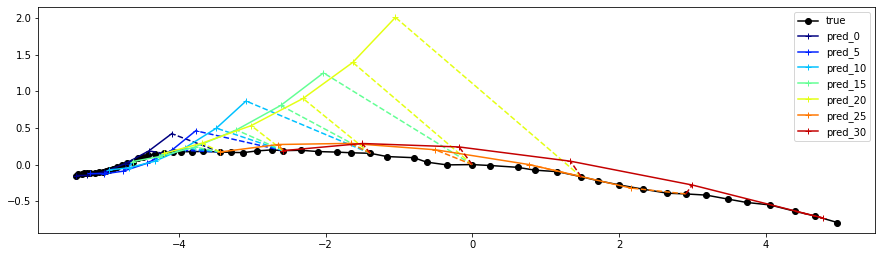

In [282]:
origin = h.true_positions[origin_idx]
origin_yaw = h.true_yaws[origin_idx]

# Center and rotate to body frame at origin_idx.
rot = np.array([
    [np.cos(origin_yaw), np.sin(origin_yaw)],
    [-np.sin(origin_yaw), np.cos(origin_yaw)]
])

true_delta = h.true_positions - origin
pred_delta = h.index_most_likely(h.pred_positions) - origin

true_delta = np.einsum("ij,tj->ti", rot, true_delta)
pred_delta = np.einsum("ij,tpj->tpi", rot, pred_delta)

plt.figure(figsize=(15, 15))
plt.plot(*true_delta.T, label="true", marker="o", color="black")

for tick_idx in range(0, h.n_ticks - h.prediction_frequency * pred_idx, h.prediction_frequency):
    color = matplotlib.cm.jet(tick_idx / (h.n_ticks - h.prediction_frequency * pred_idx - 1))
    
    # Plot the most likely predicted trajectory at tick_idx.
    traj = pred_delta[tick_idx, :pred_idx + 1]
    [line] = plt.plot(*traj.T, label=f"pred_{tick_idx}", marker="+", color=color)
    
    # Plot dotted lines to show prediction errors.
    for t, p in zip(true_delta[tick_idx::h.prediction_frequency], traj):
        plt.plot(*zip(t, p), linestyle="dashed", color=line.get_color())

plt.axes().set_aspect("equal")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


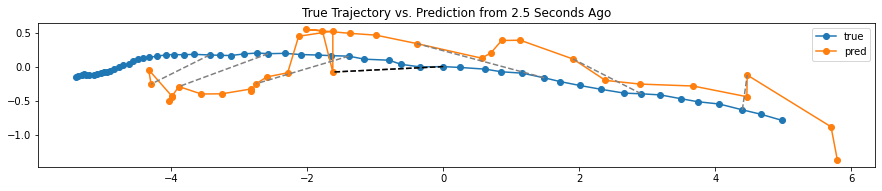

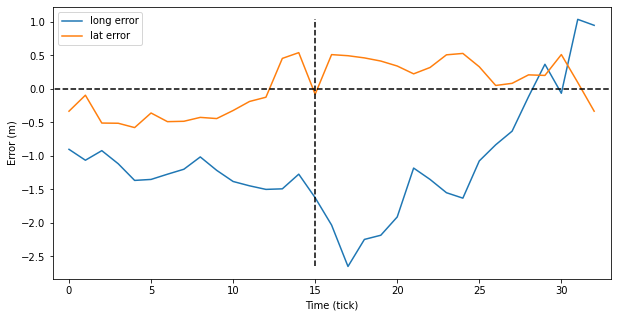

In [283]:
n_trim = pred_idx * EntityHistory.prediction_frequency
trimmed_true_delta = true_delta[n_trim:]

# keep_back = False => take the most likely mode at the time we made the prediction
# keep_back = True  => take the mode that became most likely at the time in question
keep_back = True

trimmed_pred_delta = h.index_most_likely(h.pred_positions[:-n_trim, :, pred_idx], keep_back=keep_back) - origin
trimmed_pred_delta = np.squeeze(np.expand_dims(rot, 0) @ np.expand_dims(trimmed_pred_delta, 2), 2)
assert_shape(trimmed_pred_delta, h.n_ticks - n_trim, 2)

plt.figure(figsize=(15, 15))
plt.plot(*true_delta.T, label="true", marker="o")
plt.plot(*trimmed_pred_delta.T, label="pred", marker="o")

for t, p in list(zip(trimmed_true_delta, trimmed_pred_delta))[::5]:
    plt.plot(*zip(t, p), linestyle="dashed", color="grey")
    
if origin_idx >= n_trim:
    plt.plot(*zip(true_delta[origin_idx], trimmed_pred_delta[origin_idx - n_trim]), linestyle="dashed", color="black")
    

plt.axes().set_aspect("equal")
plt.legend()
plt.title(f"True Trajectory vs. Prediction from {pred_idx * EntityHistory.prediction_frequency / 10} Seconds Ago")
plt.show()

errs = h.index_most_likely(h.get_pred_errors(pred_idx), keep_back=keep_back)
errs = assert_shape(errs, h.n_ticks - pred_idx * h.prediction_frequency, 2)

plt.figure(figsize=(10, 5))
plt.plot(errs[:, 0], label="long error")
plt.plot(errs[:, 1], label="lat error")
plt.plot([origin_idx - n_trim, origin_idx - n_trim], [np.min(errs), np.max(errs)], scaley=False, color="black", linestyle="dashed")
plt.plot([-10, h.n_ticks + 30], [0, 0], scalex=False, color="black", linestyle="dashed")


plt.legend()
plt.xlim(-1, h.n_ticks - n_trim)
plt.xlabel("Time (tick)")
plt.ylabel("Error (m)")
    
plt.show()

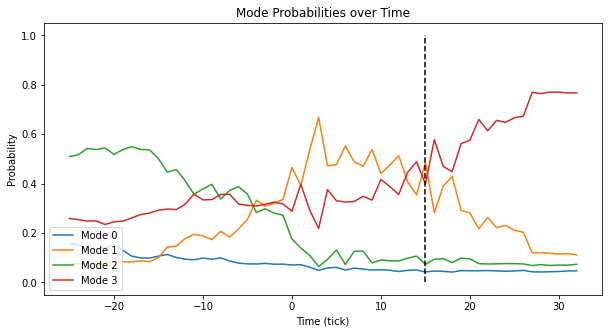

In [284]:
plt.figure(figsize=(10, 5))

for mode_idx in range(h.n_modes):
    plt.plot(np.arange(h.n_ticks) - n_trim, h.mode_probs[:, mode_idx], label=f"Mode {mode_idx}")

plt.plot([origin_idx - n_trim, origin_idx - n_trim], [0, 1], scaley=False, color="black", linestyle="dashed")
plt.legend(loc=3)
plt.xlabel("Time (tick)")
plt.ylabel("Probability")
plt.title("Mode Probabilities over Time")
plt.show()

## Longitudinal and Lateral Error

Pred idx 2 31090 data points
Pred idx 4 25401 data points
Pred idx 6 19721 data points
Pred idx 8 14067 data points


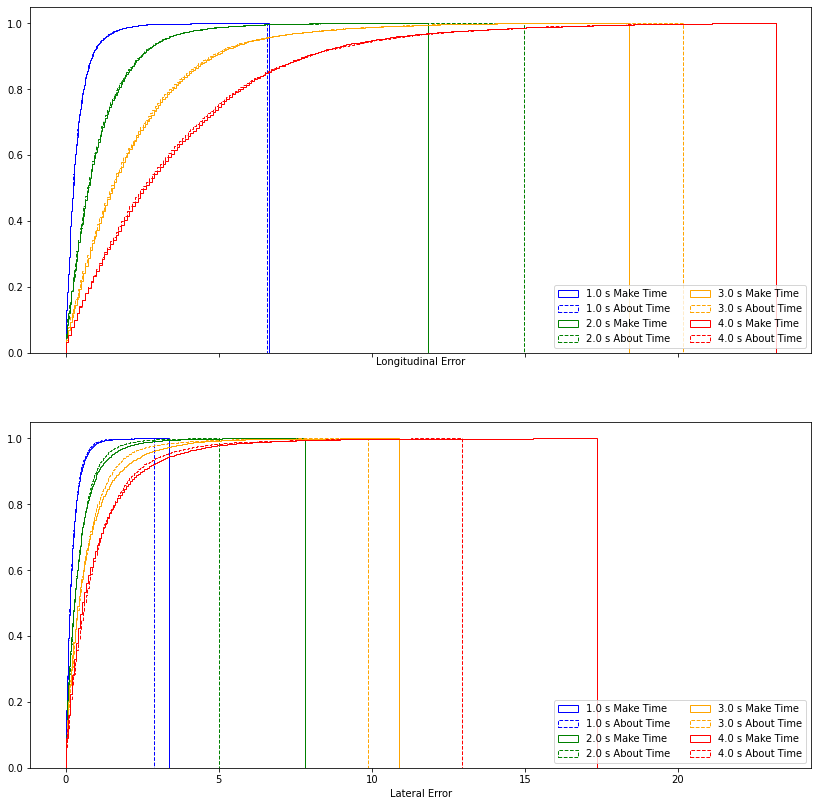

In [262]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 14))

to_display = [
    (2, "blue"),
    (4, "green"),
    (6, "orange"),
    (8, "red"),
]

hist_kwargs = dict(
    bins=256, 
    density=True,
    cumulative=True,
    histtype="step",
)

for pred_idx, color in to_display:
    time = pred_idx * EntityHistory.prediction_frequency / 10
    
    errors = np.concatenate([
        h.index_most_likely(h.get_pred_errors(pred_idx))
        for h in entity_histories], axis=0)
    errors = np.abs(errors)
    errors = assert_shape(errors, None, 2)
    print("Pred idx", pred_idx, errors.shape[0], "data points")
    
    axes[0].hist(
        errors[:, 0],
        color=color,
        label=f"{time} s Make Time",
        **hist_kwargs)
    axes[1].hist(
        errors[:, 1],
        color=color,
        label=f"{time} s Make Time",
        **hist_kwargs)
    
    errors_future_mode = np.concatenate([
        h.index_most_likely(h.get_pred_errors(pred_idx), keep_back=True)
        for h in entity_histories], axis=0)
    errors_future_mode = np.abs(errors_future_mode)
    errors_future_mode = assert_shape(errors_future_mode, None, 2)
    
    axes[0].hist(
        errors_future_mode[:, 0],
        color=color,
        linestyle="dashed",
        label=f"{time} s About Time",
        **hist_kwargs)
    axes[1].hist(
        errors_future_mode[:, 1],
        color=color,
        linestyle="dashed",
        label=f"{time} s About Time",
        **hist_kwargs)

 
for ax in axes:
    ax.legend(ncol=2, loc=4)
  
axes[0].set_xlabel("Longitudinal Error")
axes[1].set_xlabel("Lateral Error")

plt.show()

## Prediction Stabilization

Measure how much a prediction for a given point in time compares to the previous prediction for that point in time.

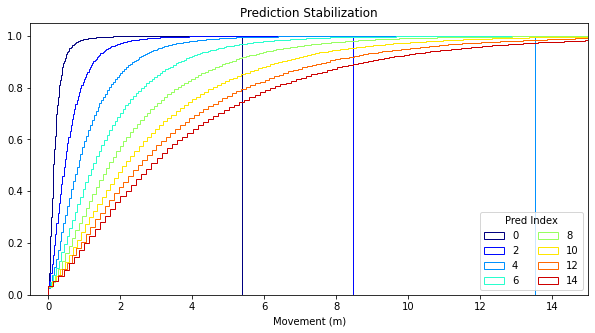

In [263]:
plt.figure(figsize=(10, 5))

for pred_idx in range(0, h.n_predictions - 1, 2):
    
    movements = np.concatenate([
        h.index_most_likely(h.get_pred_movements(pred_idx), keep_back=True)
        for h in entity_histories], axis=0)
    assert_shape(movements, None)
    
    color = matplotlib.cm.jet(pred_idx / (h.n_predictions - 2))
    
    plt.hist(
        movements, 
        color=color,
        label=f"{pred_idx}",
        **hist_kwargs)
 
plt.title("Prediction Stabilization")
plt.legend(title="Pred Index", ncol=2, loc=4)
plt.xlabel("Movement (m)")
plt.xlim(-0.5, 15)
plt.show()